In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import pyodbc
con = pyodbc.connect('DSN=ISDW')
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import naive_bayes 
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Pull APRC Data and Pull Fail Count Per Quadrant on Chip

In [2]:
daysback = 300
Calcdefs = 'S2561'
corner = 'SRAM256MST00p655CHIPA'
categoryName = 'BIT'

SQLQuery = """
SELECT lot_id_base, APRCTable.wafer_id, APRCTable.ChipX || ', ' || APRCTable.ChipY as ChipXY, family_Code,
     radius_Center_5, quadrant as waf_quadrant, locationType,
     --APRCTable.corner, categoryName as aprc, 
     BitCount, Q0FailCount, Q1FailCount, Q2FailCount, Q3FailCount
     
FROM
(
Select lot_id_base, wafer_Id, ChipX, ChipY, family_Code, radius_Center_5, quadrant, locationType, SUM(BitCount) as BitCount
FROM
(
SELECT left(lot_Id, 5) as lot_id_base, wafer_Id, normalized_TestX as ChipX, normalized_TestY as ChipY, family_Code,
     corner, categoryName, count, radius_Center_5, quadrant, locationType,
     case
         when corner = '{}' and categoryName = '{}' then count
         else 0
     end as BitCount
FROM DMIW.PattRecChipFactR prcfr
JOIN DMIW_SYSTEMS.DerivedDataSetup dds ON prcfr.derivedSetupKey = dds.derivedSetupKey
JOIN DMIW_SYSTEMS.PattRecCategory prc ON prcfr.pattRecCatKey = prc.pattRecCatKey
JOIN DMIW_SYSTEMS.Geography geo ON prcfr.geographyKey = geo.geographyKey
JOIN (select testedWaferKey, lot_Id, wafer_id, family_Code, cur_Lot_Grade as lot_Grade, last_TestTimeStamp as date,
     level, testProgramName, last_Eqp_Id
     from DMIW_SYSTEMS.TestedWafer tw
     where Last_test_date >= (current date - {} days) and Tech_id = '7HPP' and Calcdefs = '{}'
     group by testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade, last_TestTimeStamp, level, 
     testProgramName, last_Eqp_Id) tw ON prcfr.testedWaferKey = tw.testedWaferKey
WHERE categoryName <> '' and exclude_Flag = 'N'
)
GROUP BY lot_id_base, wafer_Id, ChipX, ChipY, family_Code, radius_Center_5, quadrant, locationType
ORDER BY lot_Id_base, wafer_Id, ChipX, ChipY
) APRCTable

JOIN
(
SELECT wafer_Id, ChipX, ChipY,
    SUM(Q0FailCount) as Q0FailCount, SUM(Q1FailCount) as Q1FailCount,
    SUM(Q2FailCount) as Q2FailCount, SUM(Q3FailCount) as Q3FailCount
FROM
(
SELECT wafer_Id, normalized_TestX as ChipX, normalized_TestY as ChipY, tp.parm_Label, parmValue,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q0_FBC_0P65' then parmValue
         else 0
     end as Q0FailCount,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q1_FBC_0P65' then parmValue
         else 0
     end as Q1FailCount,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q2_FBC_0P65' then parmValue
         else 0
     end as Q2FailCount,
     case
         when ucase(tp.parm_Label) = 'S256~H2~Q3_FBC_0P65' then parmValue
         else 0
     end as Q3FailCount
FROM DMIW.ChipParmFactR cpfr
JOIN DMIW_SYSTEMS.TestParm tp ON cpfr.testParmKey = tp.testParmKey
JOIN DMIW_SYSTEMS.Geography geo ON cpfr.geographyKey = geo.geographyKey
JOIN (select testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade as lot_Grade, 
     last_TestTimeStamp as date, level, last_Eqp_Id 
     from DMIW_SYSTEMS.TestedWafer testedWafer 
     where Last_test_date >= (current date - {} days) and Tech_id = '7HPP' and Calcdefs = '{}' 
     group by testedWaferKey, lot_Id, wafer_Id, family_Code, cur_Lot_Grade, last_TestTimeStamp,
     level, last_Eqp_Id) tw ON cpfr.testedWaferKey = tw.testedWaferKey
WHERE cpfr.parmValue is not null and abs(parmValue) < 1e25 and
    (ucase(tp.parm_Label) in ('S256~H2~Q0_FBC_0P65', 'S256~H2~Q1_FBC_0P65', 'S256~H2~Q2_FBC_0P65', 'S256~H2~Q3_FBC_0P65'))
)
GROUP BY wafer_Id, ChipX, ChipY
ORDER BY wafer_Id, ChipX, ChipY
) ElecTable

ON APRCTable.wafer_Id = ElecTable.wafer_Id and APRCTable.ChipX = ElecTable.ChipX and APRCTable.ChipY = ElecTable.ChipY
ORDER BY lot_Id_base, wafer_Id
""".format(corner, categoryName, daysback, Calcdefs, daysback, Calcdefs)

In [3]:
df = pd.read_sql(SQLQuery,con)

In [4]:
df[df.WAFER_ID == 'AZ2WW-11']

,LOT_ID_BASE,WAFER_ID,CHIPXY,FAMILY_CODE,RADIUS_CENTER_5,WAF_QUADRANT,LOCATIONTYPE,BITCOUNT,Q0FAILCOUNT,Q1FAILCOUNT,Q2FAILCOUNT,Q3FAILCOUNT
1708,AZ2WW,AZ2WW-11,"7, 28",HD,E,3,EDGE,280,960.0,302.0,181.0,4.0
1709,AZ2WW,AZ2WW-11,"7, 35",HD,E,2,EDGE,1582,268.0,4803.0,6.0,2283.0
1710,AZ2WW,AZ2WW-11,"16, 21",HD,E,3,INNER,60,9.0,23.0,598.0,18.0
1711,AZ2WW,AZ2WW-11,"16, 28",HD,D,3,INNER,292,61.0,96.0,71.0,64.0
1712,AZ2WW,AZ2WW-11,"16, 35",HD,D,2,INNER,366,100.0,107.0,59.0,118.0
1713,AZ2WW,AZ2WW-11,"16, 42",HD,D,2,INNER,98,18.0,378.0,20.0,30.0
1714,AZ2WW,AZ2WW-11,"25, 14",HD,D,3,INNER,20,3.0,10.0,2.0,5.0
1715,AZ2WW,AZ2WW-11,"25, 21",HD,D,3,INNER,152,50.0,35.0,43.0,24.0
1716,AZ2WW,AZ2WW-11,"25, 28",HD,C,3,INNER,1333,352.0,321.0,324.0,344.0
1717,AZ2WW,AZ2WW-11,"25, 35",HD,C,2,INNER,1965,514.0,512.0,455.0,484.0


In [5]:
pivot = pd.pivot_table(df, values=('BITCOUNT','Q0FAILCOUNT','Q1FAILCOUNT','Q2FAILCOUNT','Q3FAILCOUNT'), index=['WAFER_ID'], columns=['CHIPXY'], aggfunc=np.mean).fillna(0)

In [6]:
pivot

BITCOUNT                                                        \
CHIPXY     16, 21 16, 28 16, 35   16, 42  25, 14 25, 21  25, 28  25, 35   
WAFER_ID                                                                  
AZ2RG-01      0.0    0.0    0.0      0.0     0.0    0.0     0.0     0.0   
AZ2RG-04      1.0    2.0    2.0      1.0     2.0    1.0     3.0     4.0   
AZ2RG-06      0.0    5.0    2.0      0.0     2.0    2.0    10.0    18.0   
AZ2RG-10      0.0    1.0    1.0      0.0     0.0    0.0     8.0     8.0   
AZ2RG-17     69.0    7.0   15.0     46.0     1.0   14.0    32.0    69.0   
AZ2RU-01      3.0   29.0   20.0     19.0     0.0    4.0     3.0     9.0   
AZ2RU-02      7.0   13.0   14.0     19.0     0.0    3.0     1.0     8.0   
AZ2RU-03     24.0    7.0   27.0      2.0     0.0    9.0     7.0    20.0   
AZ2RU-04      5.0  128.0   55.0     14.0    10.0  142.0    17.0    41.0   
AZ2RU-05      3.0   24.0  113.0     36.0    14.0   24.0    11.0    21.0   
AZ2RU-08     35.0   74.0   79.0     29.0     6.0   26.0    27.0   148.0   
AZ2RU-11     33.0  273.0  198.0     13.0    27.0   44.0    42.0    89.0   
AZ2RU-12      2.0   64.0    8.0      4.0     5.0   37.0     8.0    10.0   
AZ2RU-14     23.0   16.0  126.0      3.0    17.0   40.0     4.0    48.0   
AZ2RU-15      8.0   25.0   64.0      2.0     7.0    9.0     3.0    11.0   
AZ2RU-17      8.0   28.0   16.0     35.0     5.0   13.0    10.0    28.0   
AZ2RU-18      6.0    9.0   26.0      4.0     4.0    7.0     3.0    13.0   
AZ2RU-19     15.0    6.0   10.0      1.0     2.0   19.0     2.0     8.0   
AZ2RU-20      5.0   12.0   32.0      3.0     9.0   14.0     5.0    23.0   
AZ2WW-02      2.0    3.0    0.0     22.0  2052.0   12.0   682.0    31.0   
AZ2WW-03      9.0   11.0   11.0      1.0     5.0    5.0     2.0     3.0   
AZ2WW-04      2.0   31.0   35.0      0.0    55.0  180.0    93.0    20.0   
AZ2WW-05      3.0   11.0   54.0      2.0    12.0    8.0     6.0    11.0   
AZ2WW-06      7.0    9.0    2.0      3.0    35.0  126.0    95.0    43.0   
AZ2WW-07     42.0   55.0   74.0     19.0   239.0  315.0   172.0   268.0   
AZ2WW-09      9.0   22.0   71.0      6.0     5.0    8.0     8.0    23.0   
AZ2WW-10     30.0  138.0  221.0     35.0    23.0  106.0   888.0  1570.0   
AZ2WW-11     60.0  292.0  366.0     98.0    20.0  152.0  1333.0  1965.0   
AZ2WW-12     75.0  344.0  264.0     75.0    36.0  470.0  1020.0  1437.0   
AZ2WW-13     24.0   87.0  140.0     29.0     9.0   57.0   314.0   541.0   
...           ...    ...    ...      ...     ...    ...     ...     ...   
AZ3VK-01    248.0  301.0  213.0   1944.0   302.0  330.0   237.0   153.0   
AZ3VK-02    126.0   38.0   43.0    911.0    19.0   57.0    38.0    36.0   
AZ3VK-03    332.0  231.0  134.0   7909.0   335.0  550.0   397.0   192.0   
AZ3VK-04    120.0  132.0   52.0     64.0   164.0  176.0    75.0    41.0   
AZ3VK-05     29.0   38.0   38.0   5205.0    17.0   92.0    42.0    13.0   
AZ3VK-06    113.0  104.0   47.0     41.0   137.0  192.0   100.0    59.0   
AZ3VK-08    598.0  195.0   92.0    115.0   215.0  242.0   121.0    82.0   
AZ3VK-09     31.0   30.0   20.0   4676.0     9.0   35.0    26.0     9.0   
AZ3VK-13     71.0  131.0   75.0   1992.0   123.0  204.0   166.0    48.0   
AZ3VK-16     39.0   16.0   12.0   1919.0     4.0   17.0    16.0     2.0   
AZ3WV-01    215.0   41.0   25.0   1121.0   554.0   44.0    37.0    70.0   
AZ3WV-02    140.0   13.0   26.0   1807.0     7.0   17.0    10.0   111.0   
AZ3WV-03     90.0   42.0   53.0  14740.0    42.0   18.0    39.0     4.0   
AZ3WV-04     39.0   16.0   17.0    115.0    14.0   26.0    19.0    23.0   
AZ3WV-05    245.0   39.0  937.0  34403.0    15.0   21.0    10.0    15.0   
AZ3WV-06    146.0   16.0   68.0   1199.0    17.0   19.0    10.0    12.0   
AZ3WV-07    134.0   48.0   69.0   6530.0    18.0    9.0     8.0     7.0   
AZ3WV-08     27.0    9.0   90.0    698.0    10.0   13.0     3.0     4.0   
AZ3WV-09     14.0    9.0   28.0   4251.0    13.0   11.0    31.0     4.0   
AZ3WV-10     23.0   13.0   19.0   

In [7]:
labels = pd.read_csv("data/7nmLabels.csv")

In [8]:
train = pivot.join(labels.set_index('WAFER_ID')['Smiley']).dropna()

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
train.to_csv('/Users/acyang@us.ibm.com/Downloads/asdf.csv')

### Random Forest Model

In [9]:
def find_model_accuracy(train_data, train_labels, test_data, test_labels, model):
    # Fit the model to the training set
    model.fit(train_data, train_labels)
    test_predict = model.predict(test_data)
    
    # plot_confusion matrix
    sns.heatmap(metrics.confusion_matrix(test_labels, test_predict), 
                xticklabels=['pred: Neg', 'pred: Pos'],
                annot=True,
                fmt='g',
                cmap='Blues').set_yticklabels(['actual: Neg', 'actual: Pos'], rotation=0)
    plt.tight_layout()

    plt.show()
    # return accuracy
    return metrics.accuracy_score(test_predict, test_labels), test_predict, test_labels

In [28]:
# Split Train and Test Sets
train_data, test_data, train_labels, test_labels = train_test_split(train.loc[:, train.columns != 'Smiley'], train[['Smiley']], test_size=0.2)

In [30]:
# Quick Model RandomForestClassifier
X,y = train.loc[:, train.columns != 'Smiley'], train['Smiley']
#X,y = train_data, train_labels['Smiley']
model = ensemble.RandomForestClassifier(class_weight='balanced', criterion='gini',
                                            max_depth=7, n_estimators=220, n_jobs=-1)
#accuracy, predict, actual = find_model_accuracy(X, y, test_data, test_labels['Smiley'], model)
model.fit(X, y)
#print(accuracy)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=220, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [10]:
# RandomForestClassifier
X,y = train.loc[:, train.columns != 'Smiley'], train['Smiley']
clf = ensemble.RandomForestClassifier(n_jobs=-1)

# Gridsearch CV
parameter_grid = {'max_depth' : np.arange(5, 12, 1),
                 'n_estimators': np.arange(200, 250, 10),
                 'criterion': ['gini','entropy'],
                 'class_weight': [None ,'balanced']}

grid_search = model_selection.GridSearchCV(clf, parameter_grid)
grid_search.fit(X, y)
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=220, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

average accuracy score: 0.987030303030303


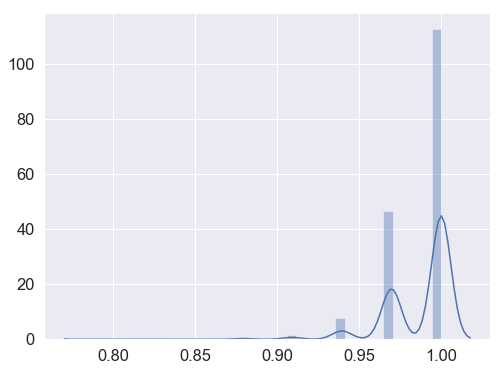

In [11]:
# Model accuracy
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

In [26]:
# Create a dataframe showing all the mistakes made by the classifier
fail_analysis = actual.to_frame()
fail_analysis['predicted'] = predict

In [27]:
fail_analysis

,Smiley,predicted
WAFER_ID,,
AZ3WW-05,1.0,0.0
AZ377-11,0.0,0.0
AZ3FX-05,0.0,0.0
AZ377-14,0.0,0.0
AZ3WV-10,0.0,0.0
AZ2WW-12,0.0,0.0
AZ3HB-10,0.0,0.0
AZ2Y4-04,0.0,0.0
AZ377-12,0.0,0.0


### Bernoulli Naive Bayes Model

In [12]:
# Bernoulli Naive Bayes Model
X,y = train.loc[:, train.columns != 'Smiley'], train['Smiley']
clf = naive_bayes.BernoulliNB()

# Gridsearch CV
parameter_grid = {'alpha' : [0.00000001, 0.0001, 0.001, 0.01, 0.1, 1]}

grid_search = model_selection.GridSearchCV(clf, parameter_grid)
grid_search.fit(X, y)
grid_search.best_estimator_

BernoulliNB(alpha=1e-08, binarize=0.0, class_prior=None, fit_prior=True)

average accuracy score: 0.9179393939393938


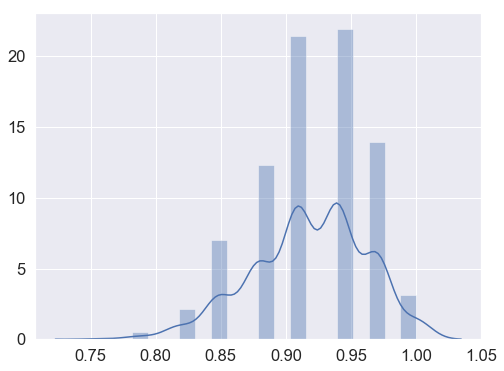

In [13]:
# Model accuracy
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

### K Nearest Neighbors

In [14]:
# K Nearest Neighbors Model
X,y = train.loc[:, train.columns != 'Smiley'], train['Smiley']
clf = KNeighborsClassifier(n_jobs = -1)

# Gridsearch CV
parameter_grid = {'n_neighbors' : np.arange(5,20,1),
                 'weights' : ['uniform', 'distance'],}

grid_search = model_selection.GridSearchCV(clf, parameter_grid)
grid_search.fit(X, y)
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

average accuracy score: 0.9256363636363635


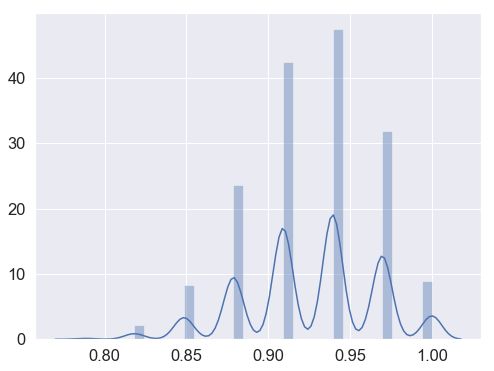

In [15]:
# Model accuracy
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=.2)
cv_scores = model_selection.cross_val_score(clf, X, y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

In [31]:
model.predict_proba(train.loc[:, train.columns != 'Smiley'])[:,1]

array([0.        , 0.        , 0.        , 0.        , 0.00454545,
       0.00909091, 0.        , 0.        , 0.        , 0.01363636,
       0.01363636, 0.01818182, 0.00454545, 0.        , 0.01363636,
       0.        , 0.        , 0.        , 0.        , 0.02272727,
       0.        , 0.05909091, 0.        , 0.00454545, 0.03181818,
       0.        , 0.00454545, 0.01363636, 0.06818182, 0.00454545,
       0.00454545, 0.01818182, 0.05      , 0.00454545, 0.00454545,
       0.11363636, 0.02272727, 0.12272727, 0.        , 0.00909091,
       0.        , 0.        , 0.        , 0.01363636, 0.02272727,
       0.01363636, 0.00454545, 0.        , 0.00454545, 0.        ,
       0.        , 0.00454545, 0.01818182, 0.00454545, 0.00909091,
       0.        , 0.00454545, 0.00454545, 0.        , 0.        ,
       0.        , 0.00454545, 0.        , 0.00454545, 0.        ,
       0.        , 0.00454545, 0.        , 0.        , 0.00454545,
       0.        , 0.        , 0.        , 0.        , 0.     

In [33]:
results = pd.DataFrame({'actual':train.Smiley,'predicted':model.predict(train.loc[:, train.columns != 'Smiley']),
                        'probability':model.predict_proba(train.loc[:, train.columns != 'Smiley'])[:,1]})

In [34]:
results.to_csv('~/Downloads/Smiley.csv')